# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Jan 19 19:33:27 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# 1. Force uninstall both to clear the conflict
!pip uninstall -y unsloth unsloth_zoo

# 2. Install Unsloth Zoo DIRECTLY from Git (to get 'tiled_mlp')
!pip install --upgrade --no-cache-dir "unsloth_zoo @ git+https://github.com/unslothai/unsloth-zoo.git"

# 3. Install Unsloth main library from Git
!pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2026.1.3
Uninstalling unsloth-2026.1.3:
  Successfully uninstalled unsloth-2026.1.3
Found existing installation: unsloth_zoo 2026.1.3
Uninstalling unsloth_zoo-2026.1.3:
  Successfully uninstalled unsloth_zoo-2026.1.3
  Cloning https://github.com/unslothai/unsloth-zoo.git to /tmp/pip-install-bbfec_cx/unsloth-zoo_3dbfd579963b444db88e2090965cf48b
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth-zoo.git /tmp/pip-install-bbfec_cx/unsloth-zoo_3dbfd579963b444db88e2090965cf48b
  Resolved https://github.com/unslothai/unsloth-zoo.git to commit 22a6de416298d81514fcb48d05e51bca6be26909
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 19.3 MB/s eta 0:00:00
  Created wheel for unsloth_zoo: filename=unsloth_zoo-2026.1.3-py3-none-any.whl size=309334 sha256=b607d66abec3aca261c117be

In [4]:
!pip install "datasets<3.0.0"


  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
Using cached datasets-2.21.0-py3-none-any.whl (527 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 4.3.0
    Uninstalling datasets-4.3.0:
      Successfully uninstalled datasets-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trl 0.24.0 requires datasets>=3.0.0, but you have datasets 2.21.0 which is incompatible.
unsloth-zoo 2026.1.3 requires datasets!=4.0.*,!=4.1.0,<4.4.0,>=3.4.1, but you have datasets 2.21.0 which is incompatible.


In [5]:
!pip install bert-extractive-summarizer

In [6]:
!pip install pytorch-ignite
!pip install torchmetrics

## importowanie datesetu

In [7]:
from datasets import load_dataset


ds = load_dataset("xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 750)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 32053
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1746
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1727
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [9]:
from summarizer import Summarizer
model = Summarizer()

In [10]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [23]:
num_workers = 1
batch_size = 50

In [26]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(10))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 10
})


In [30]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]

        inputs = tokenizer(
            prompted,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096,
        )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    print(f"Doc: {batch['document'][0][:100]}")
    print(f"Prediction: {predictions[0]}")
    print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]

    print(predictions)
    print(targets)

    m.update((predictions, targets))
    print(m.compute())
    return m.compute()

In [45]:
from matplotlib import pyplot as plt
def plot_data(data, labels = ['Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F','Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F']):
  plt.bar(labels, data)
  plt.ylim(0, 1)
  plt.ylabel('Score')
  plt.show()

In [14]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [15]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [16]:
import numpy as np
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
) -> float:
    results = []

    for i, batch in enumerate(data_loader):

        m = Rouge(variants=["L", 1], multiref="best")

        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [17]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
        )

    return loss




In [33]:
from torch import nn
loss = evaluate_model(model, test_loader, device='cuda', bert=True, tokenizer=None)
print(loss)



Doc: It will connect the A4232 at the Queensgate roundabout with the Ocean Way roundabout in Tremorfa.
Th
Prediction: It will connect the A4232 at the Queensgate roundabout with the Ocean Way roundabout in Tremorfa. The Eastern Bay Link Road was part of a deal in 2014 between Labour and the Liberal Democrats to pass the Welsh Government's budget.
Target: A £57m road linking Cardiff Bay and the east of the city will officially open on Thursday.
[['it', 'will', 'connect', 'the', 'a4232', 'at', 'the', 'queensgate', 'roundabout', 'with', 'the', 'ocean', 'way', 'roundabout', 'in', 'tremorfa', 'the', 'eastern', 'bay', 'link', 'road', 'was', 'part', 'of', 'a', 'deal', 'in', '2014', 'between', 'labour', 'and', 'the', 'liberal', 'democrats', 'to', 'pass', 'the', 'welsh', 'government', 's', 'budget'], ['media', 'playback', 'is', 'not', 'supported', 'on', 'this', 'device', 'enjoy', 'the', 'key', 'moments', 'of', 'their', 'fantastic', '1', '0', 'victory', 'as', 'bbc', 'radio', 'listeners', 'heard'

In [19]:
summary = "\n###Summary\n"

In [20]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text:"
            prompt += f'[TEXT]{batch['document'][i]}\n[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    return prompt


In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer3 = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-0.5B")
tokenizer3.padding_side = 'left'
if tokenizer3.pad_token is None:
    tokenizer3.pad_token = tokenizer3.eos_token
    # Some models also require explicitly setting the pad_token_id
    tokenizer3.pad_token_id = tokenizer3.eos_token_id
model3 = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B")




In [39]:
prompt3 = generate_prompt(tokenizer3, 0)
data = evaluate_model(model3, test_loader, device='cuda', bert=False, tokenizer=tokenizer3, prompt=prompt3, promptsuff = summary)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: London Fire Brigade said it was called to the arena on Millennium Way, Greenwich, at about 11:15 BST
Prediction: The London Fire Brigade said it was called to the arena on Millennium Way, Greenwich, at about 11:15 BST. About 21 firefighters tackled the blaze, which was contained to the restaurant's extraction system. The cause of the
Target: More than 1,200 people were evacuated from the O2 Arena in London due to a fire at a restaurant.
[['the', 'london', 'fire', 'brigade', 'said', 'it', 'was', 'called', 'to', 'the', 'arena', 'on', 'millennium', 'way', 'greenwich', 'at', 'about', '11', '15', 'bst', 'about', '21', 'firefighters', 'tackled', 'the', 'blaze', 'which', 'was', 'contained', 'to', 'the', 'restaurant', 's', 'extraction', 'system', 'the', 'cause', 'of', 'the'], ['the', 'a4232', 'will', 'connect', 'the', 'a4232', 'at', 'the', 'queensgate', 'roundabout', 'with', 'the', 'ocean', 'way', 'roundabout', 'in', 'tremorfa', 'the', 'eastern', 'bay', 'link', 'road', 'was', 'part', 'of'

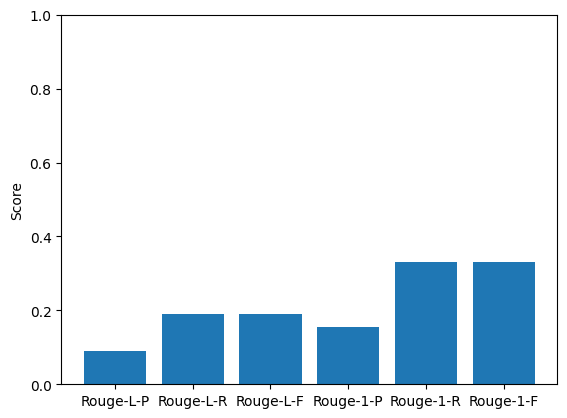

In [46]:
plot_data(data)

In [34]:
prompt4 = "[USER]Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
print(
    evaluate_model(
        model3,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer3,
        prompt=prompt4,
    )
)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: The project at Ffrwd Farm Nature Reserve, Pembrey, is part of a wider ongoing water vole strategy fo
Prediction:  The first one was in 2015.
The project at Ffrwd Farm Nature Reserve, Pembrey, is part of a wider ongoing water voles strategy for south Wales.
The Welsh Government has announced that it will be funding the project
Target: Water voles are being reintroduced at a Carmarthenshire nature reserve.
[['the', 'first', 'one', 'was', 'in', '2015', 'the', 'project', 'at', 'ffrwd', 'farm', 'nature', 'reserve', 'pembrey', 'is', 'part', 'of', 'a', 'wider', 'ongoing', 'water', 'voles', 'strategy', 'for', 'south', 'wales', 'the', 'welsh', 'government', 'has', 'announced', 'that', 'it', 'will', 'be', 'funding', 'the', 'project'], ['the', '50', 'year', 'old', 'man', 'is', 'believed', 'to', 'have', 'been', 'driving', 'the', 'white', 'toyota', 'corolla', 'with', 'a', 'number', 'plate', 'of', '144s', 'in', 'the', 'car', 'park', 'of', 'the', 'building', 'the', 'man', 'is', 'being', 'kept', 

In [57]:
import torch

print(torch.cuda.is_available())

True


In [ ]:
# !pip install -U bitsandbytes

In [ ]:
from unsloth import FastLanguageModel

ft_model, ft_tokenzier = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen1.5-0.5B", max_seq_length=4096, load_in_4bit=False
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/tmp/ipython-input-4133930992.py:1: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.3: Fast Qwen2 patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The following TP rules were not applied on any of the layers: {'layers.*.self_attn.q_proj': 'colwise', 'layers.*.self_attn.k_proj': 'colwise', 'layers.*.self_attn.v_proj': 'colwise', 'layers.*.self_attn.o_proj': 'rowwise', 'layers.*.mlp.gate_proj': 'colwise', 'layers.*.mlp.up_proj': 'colwise', 'layers.*.mlp.down_proj': 'rowwise'}
The following layers were not sharded: model.embed_tokens.weight, model.layers.*.input_layernorm.weight, model.layers.*.post_attention_layernorm.weight, lm_head.weight, model.layers.*.self_attn.q_proj.weight, model.norm.weight, model.layers.*.self_attn.k_proj.weight, model.layers.*.self_attn.v_proj.bias


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Qwen/Qwen1.5-0.5B does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.


In [ ]:
ft_ds = ds


def merge_columns(example):
    example["text"] = (
        f"{example['document']}\n### Summary\n{example['summary']}"
    )
    return example

ft_ds = ft_ds.map(merge_columns)

Map:   0%|          | 0/32053 [00:00<?, ? examples/s]

Map:   0%|          | 0/1746 [00:00<?, ? examples/s]

Map:   0%|          | 0/1727 [00:00<?, ? examples/s]

In [ ]:
print(ft_ds)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id', 'text'],
        num_rows: 32053
    })
    validation: Dataset({
        features: ['document', 'summary', 'id', 'text'],
        num_rows: 1746
    })
    test: Dataset({
        features: ['document', 'summary', 'id', 'text'],
        num_rows: 1727
    })
})


In [ ]:
from trl import SFTTrainer, SFTConfig
ft_model = FastLanguageModel.get_peft_model(
    ft_model,
    r=16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                  "gate_proj", "up_proj", "down_proj",],
    lora_alpha=64,
    lora_dropout=0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state=1234,
    use_rslora = False,
    loftq_config = None,

)
trainer = SFTTrainer(
    model=ft_model,
    train_dataset=ft_ds["train"],
    eval_dataset=ft_ds["validation"],
    tokenizer=ft_tokenzier,
    args=SFTConfig(
        max_seq_length=4096,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        # num_train_epochs=1,
        max_steps=200,
        logging_steps=1,
        output_dir="outputs",
        optim="adamw_8bit",
        seed=3407,
        eval_strategy="steps",
        eval_steps=200,
    ),
)
trainer.train()

Unsloth: Already have LoRA adapters! We shall skip this step.


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/32053 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/1746 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 32,053 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 7,569,408 of 471,557,120 (1.61% trained)


Step,Training Loss,Validation Loss
200,2.352300,2.475542
400,2.413400,2.455956
600,2.704300,2.444260
800,2.306100,2.437634
1000,2.576900,2.434757


TrainOutput(global_step=1000, training_loss=2.43309379196167, metrics={'train_runtime': 1380.8214, 'train_samples_per_second': 5.794, 'train_steps_per_second': 0.724, 'total_flos': 2412709167095808.0, 'train_loss': 2.43309379196167, 'epoch': 0.24957883571473138})

In [ ]:
evaluate_model(ft_model, test_loader, 'cuda', 10, bert=False, tokenizer = ft_tokenzier, promptsuff = "\n### Summary\n")

Doc: A party spokesperson said the timing made it "impractical" to put together and finance "a meaningful
Prediction: The Conservatives have decided to withdraw from the general election after losing funding for a planned campaign. The party is now planning to field candidates in 2017.
Target: Mebyon Kernow, which campaigns for a National Assembly for Cornwall, has announced it will not be putting forward any candidates for the 2017 general election.


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.bias, encoder.rel_embeddings.weight, embeddings.LayerNorm.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.weight, encoder.layer.*.attention.self.query_proj.bias, encoder.layer.*.attention.self.key_proj.bias, encoder.layer.*.attention.self.query_proj.weight, embeddings.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key_proj.weight, encoder.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight


Doc: Two were picked up by a coastguard helicopter high up on the 3,196ft (974 metre) Munro.
Lomond Mount
Prediction: Two people have been rescued after a dog and a hare were swept up in snow in the Highlands. The rescue team said the dogs had been taken to a local animal shelter.
Target: Four hillwalkers who got into difficulties during severe weather on Ben Lomond have been rescued.


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.bias, encoder.rel_embeddings.weight, embeddings.LayerNorm.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.weight, encoder.layer.*.attention.self.query_proj.bias, encoder.layer.*.attention.self.key_proj.bias, encoder.layer.*.attention.self.query_proj.weight, embeddings.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key_proj.weight, encoder.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight


Doc: She will talk about her life outside of politics, including television appearances on Strictly Come 
Prediction: BBC Radio 4's BBC Radio 4 Music festival is to feature a series of talks by musicians.
Target: Former Conservative politician Ann Widdecombe will headline this year's Nairn Book and Arts Festival.


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.bias, encoder.rel_embeddings.weight, embeddings.LayerNorm.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.weight, encoder.layer.*.attention.self.query_proj.bias, encoder.layer.*.attention.self.key_proj.bias, encoder.layer.*.attention.self.query_proj.weight, embeddings.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key_proj.weight, encoder.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight


Doc: The 20-year-old striker was sent off by Mike Jones in Blues' 2-0 win on Saturday.
But an FA Regulato
Prediction: Steven Adams has been ruled out for the rest of the season by the Football Association. The 26-year-old has been fined for his actions.
Target: Che Adams will be available to play in Birmingham City's final game of the season after his red card against Huddersfield was rescinded.


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.bias, encoder.rel_embeddings.weight, embeddings.LayerNorm.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.weight, encoder.layer.*.attention.self.query_proj.bias, encoder.layer.*.attention.self.key_proj.bias, encoder.layer.*.attention.self.query_proj.weight, embeddings.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key_proj.weight, encoder.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight


Doc: The 66-year-old, of Ballybinaby, Hackballscross, County Louth, faces nine tax charges at the Republi
Prediction: A man accused of tax fraud has been remanded in custody in Dublin. He is accused of failing to make tax returns for 12 years. The case is still being investigated.
Target: The trial of the prominent republican Thomas "Slab" Murphy for alleged tax evasion has heard the court may deliver judgement on the case next week.


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.bias, encoder.rel_embeddings.weight, embeddings.LayerNorm.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.weight, encoder.layer.*.attention.self.query_proj.bias, encoder.layer.*.attention.self.key_proj.bias, encoder.layer.*.attention.self.query_proj.weight, embeddings.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key_proj.weight, encoder.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight


Doc: The 23-year-old midfielder is his country's joint all-time goalscorer, with two goals from 11 caps.

Prediction: Gibraltar international goalkeeper Alex Craggs has signed a new two-year contract with Torquay United. The 23-year-old was loaned out to Forest Green last season.
Target: Torquay United have signed Gibraltar international Jake Gosling following his release by Bristol Rovers.


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.bias, encoder.rel_embeddings.weight, embeddings.LayerNorm.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.weight, encoder.layer.*.attention.self.query_proj.bias, encoder.layer.*.attention.self.key_proj.bias, encoder.layer.*.attention.self.query_proj.weight, embeddings.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key_proj.weight, encoder.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight


Doc: Led by Rev Syd Graham, the private service for the couple from Bankfoot was held in Perth Crematoriu
Prediction: The funeral of a couple who lost their lives in the Paris attacks has been held outside a crematorium in Scotland. The couple was in their 50s and had been celebrating their 50th anniversary.
Target: The funeral for Billy and Lisa Graham, who were killed in last month's terror attacks in Tunisia, has taken place.


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.bias, encoder.rel_embeddings.weight, embeddings.LayerNorm.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.weight, encoder.layer.*.attention.self.query_proj.bias, encoder.layer.*.attention.self.key_proj.bias, encoder.layer.*.attention.self.query_proj.weight, embeddings.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key_proj.weight, encoder.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight


Doc: Craig Nelson, who was also known as Craig Preston, was found at the Woodhead Tunnels off the A628 in
Prediction: A man and a woman have been arrested in connection with the death of a man who was found dead in a field in Derbyshire. The 23-year-old man, who is not expected to survive, was found dead in the field close to
Target: Police have arrested two people on suspicion of murder after a man's body was found on moorland.


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.bias, encoder.rel_embeddings.weight, embeddings.LayerNorm.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.weight, encoder.layer.*.attention.self.query_proj.bias, encoder.layer.*.attention.self.key_proj.bias, encoder.layer.*.attention.self.query_proj.weight, embeddings.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key_proj.weight, encoder.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight


Doc: Twenty hostages and two police officers died during a 12-hour siege when Islamic militants stormed a
Prediction: England and Wales Cricket Board (ECB) have issued a statement following the death of 12 people in an attack on a cricket venue in Bangladesh. The ECB will consult with the Foreign and Commonwealth Office and take appropriate steps to ensure the safety of
Target: The England and Wales Cricket Board says it is monitoring the security situation in Bangladesh before England's tour in October.


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.bias, encoder.rel_embeddings.weight, embeddings.LayerNorm.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.weight, encoder.layer.*.attention.self.query_proj.bias, encoder.layer.*.attention.self.key_proj.bias, encoder.layer.*.attention.self.query_proj.weight, embeddings.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key_proj.weight, encoder.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight


Doc: The 25-year-old steps up to the National League after 22 appearances for Rushall this season.
He is 
Prediction: Rams defender Jonny Langley has signed a new deal at the club, while defender Jean-Yves Koue Niate and midfielder Donnell Benjamin have both left the club.
Target: Solihull Moors have signed centre-back Joel Kettle from Northern League Premier leaders Rushall Olympic.


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.bias, encoder.rel_embeddings.weight, embeddings.LayerNorm.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.weight, encoder.layer.*.attention.self.query_proj.bias, encoder.layer.*.attention.self.key_proj.bias, encoder.layer.*.attention.self.query_proj.weight, embeddings.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key_proj.weight, encoder.LayerNorm.bias, encoder.layer.*.attention.self.value_proj.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight


{'precision': tensor([0.8252, 0.7663, 0.7594, 0.8084, 0.8045, 0.8024, 0.8082, 0.7796, 0.8173,
        0.7991]), 'recall': tensor([0.7766, 0.7910, 0.7766, 0.8207, 0.7825, 0.8479, 0.8054, 0.8244, 0.8363,
        0.7834]), 'f1': tensor([0.8002, 0.7785, 0.7679, 0.8145, 0.7934, 0.8245, 0.8068, 0.8014, 0.8267,
        0.7912])}


(tensor(0.7970), tensor(0.8045), tensor(0.8005))

In [ ]:
ft_model.save_pretrained('./drive/MyDrive/models/ft')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
